In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv('./data/mental_health_and_technology_usage_2024.csv')

# Первичный анализ дата сета


### Посмотрим на первые 5 строк дата сета

In [97]:
data.head()

,User_ID,Age,Gender,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Mental_Health_Status,Stress_Level,Sleep_Hours,Physical_Activity_Hours,Support_Systems_Access,Work_Environment_Impact,Online_Support_Usage
0,USER-00001,23,Female,6.57,6.00,0.68,12.36,Good,Low,8.01,6.71,No,Negative,Yes
1,USER-00002,21,Male,3.01,2.57,3.74,7.61,Poor,High,7.28,5.88,Yes,Positive,No
2,USER-00003,51,Male,3.04,6.14,1.26,3.16,Fair,High,8.04,9.81,No,Negative,No
3,USER-00004,25,Female,3.84,4.48,2.59,13.08,Excellent,Medium,5.62,5.28,Yes,Negative,Yes
4,USER-00005,53,Male,1.20,0.56,0.29,12.63,Good,Low,5.55,4.00,No,Positive,Yes


### Посмотрим на размер дата сета  и типы данных

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User_ID                   10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Gender                    10000 non-null  object 
 3   Technology_Usage_Hours    10000 non-null  float64
 4   Social_Media_Usage_Hours  10000 non-null  float64
 5   Gaming_Hours              10000 non-null  float64
 6   Screen_Time_Hours         10000 non-null  float64
 7   Mental_Health_Status      10000 non-null  object 
 8   Stress_Level              10000 non-null  object 
 9   Sleep_Hours               10000 non-null  float64
 10  Physical_Activity_Hours   10000 non-null  float64
 11  Support_Systems_Access    10000 non-null  object 
 12  Work_Environment_Impact   10000 non-null  object 
 13  Online_Support_Usage      10000 non-null  object 
dtypes: floa

### Посмотрим на статистику дата сета

In [99]:
data.describe()

,Age,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Sleep_Hours,Physical_Activity_Hours
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,41.518600,6.474341,3.972321,2.515598,7.975765,6.500724,5.003860
std,13.920217,3.169022,2.313707,1.446748,4.042608,1.450933,2.905044
min,18.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000
25%,29.000000,3.760000,1.980000,1.260000,4.520000,5.260000,2.490000
50%,42.000000,6.425000,3.950000,2.520000,7.900000,6.500000,4.990000
75%,54.000000,9.212500,5.990000,3.790000,11.500000,7.760000,7.540000
max,65.000000,12.000000,8.000000,5.000000,15.000000,9.000000,10.000000


### Посмотрим на количество пропущенных значений

In [100]:
data.isnull().sum()

User_ID                     0
Age                         0
Gender                      0
Technology_Usage_Hours      0
Social_Media_Usage_Hours    0
Gaming_Hours                0
Screen_Time_Hours           0
Mental_Health_Status        0
Stress_Level                0
Sleep_Hours                 0
Physical_Activity_Hours     0
Support_Systems_Access      0
Work_Environment_Impact     0
Online_Support_Usage        0
dtype: int64

### Посмотрим на количество дубликатов

In [101]:
print(data.duplicated().sum())

0


### Посмотрим на количество уникальных значений

In [102]:
data.nunique()

User_ID                     10000
Age                            48
Gender                          3
Technology_Usage_Hours       1101
Social_Media_Usage_Hours      801
Gaming_Hours                  501
Screen_Time_Hours            1400
Mental_Health_Status            4
Stress_Level                    3
Sleep_Hours                   501
Physical_Activity_Hours      1001
Support_Systems_Access          2
Work_Environment_Impact         3
Online_Support_Usage            2
dtype: int64

In [103]:
data['Age'].unique()

array([23, 21, 51, 25, 53, 58, 63, 57, 31, 64, 40, 24, 38, 26, 55, 37, 34,
       39, 42, 27, 50, 60, 20, 29, 30, 47, 41, 44, 48, 45, 59, 62, 28, 32,
       49, 33, 18, 36, 19, 22, 35, 46, 56, 54, 61, 52, 65, 43])

### Посмотрим на распределение значений в колонке Age

In [104]:
data['Age'].value_counts()

Age
62    245
59    235
32    231
65    230
45    226
38    224
50    224
25    222
26    220
18    220
46    218
53    218
57    218
23    216
21    216
22    216
49    215
42    214
20    214
52    214
29    213
24    212
27    210
37    208
64    208
41    208
34    207
36    207
63    207
33    206
40    205
56    203
43    203
44    202
55    198
39    197
35    197
30    196
58    196
54    194
51    191
28    190
61    187
31    186
60    186
48    186
47    183
19    178
Name: count, dtype: int64

In [105]:
data['Age'].describe()

count    10000.000000
mean        41.518600
std         13.920217
min         18.000000
25%         29.000000
50%         42.000000
75%         54.000000
max         65.000000
Name: Age, dtype: float64

# Анализ данных

### Посмотрим на распределение признаков


Анализ распределения для признака: Age


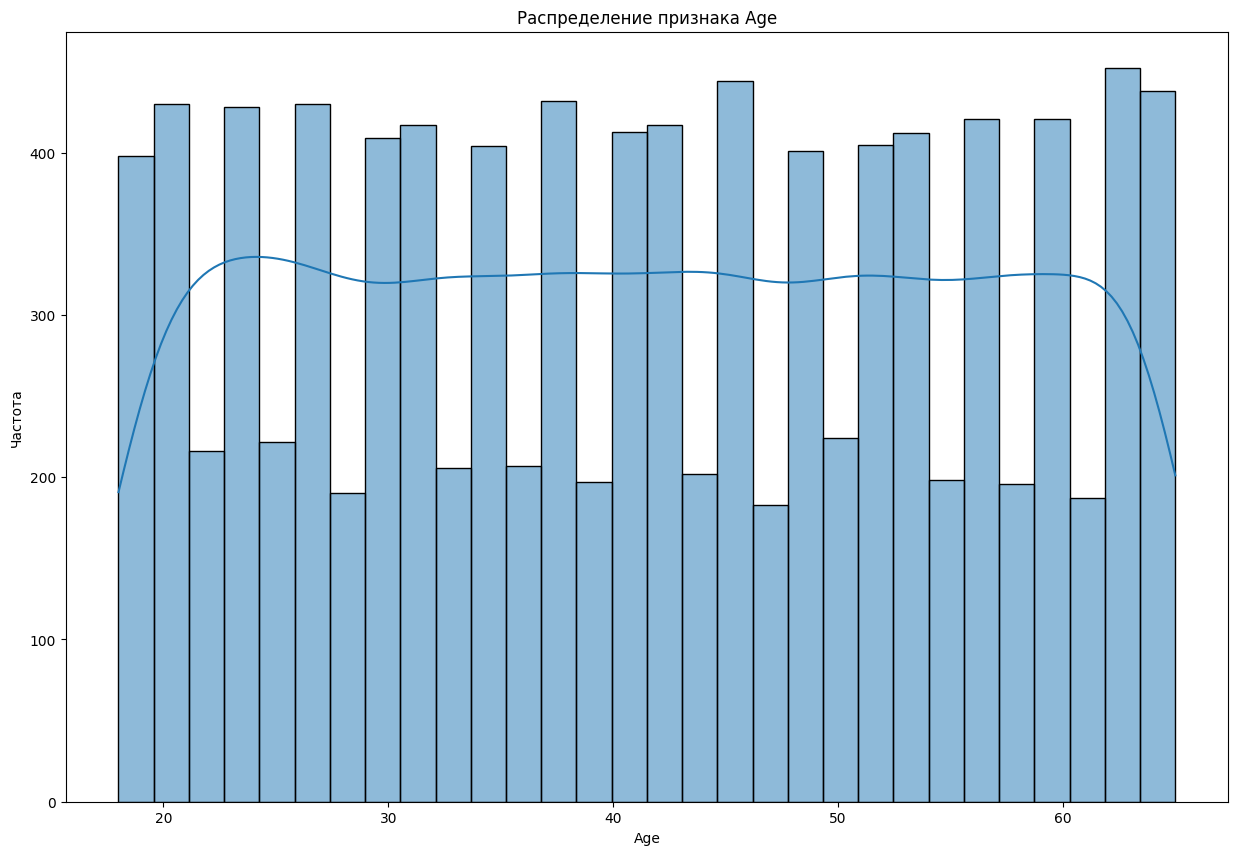

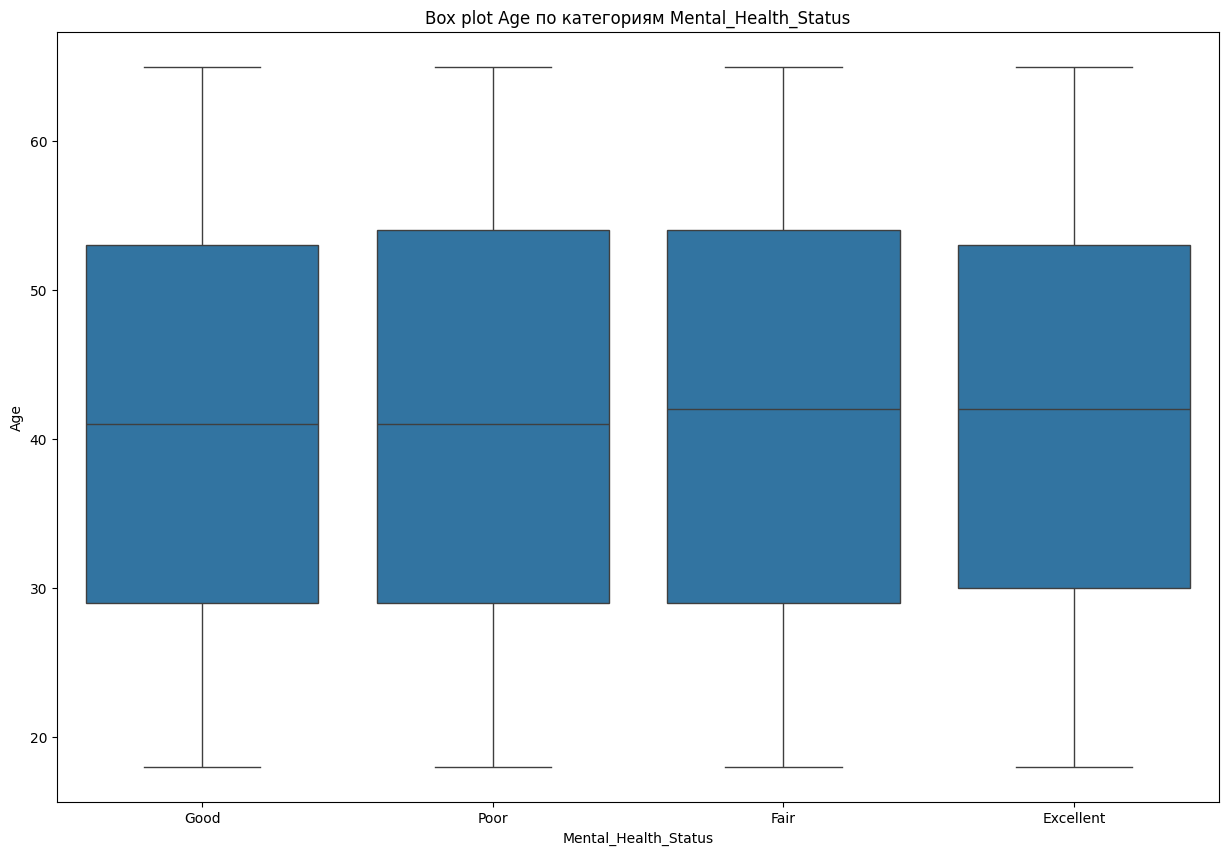

Базовая статистика для Age:
count    10000.000000
mean        41.518600
std         13.920217
min         18.000000
25%         29.000000
50%         42.000000
75%         54.000000
max         65.000000
Name: Age, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Gender


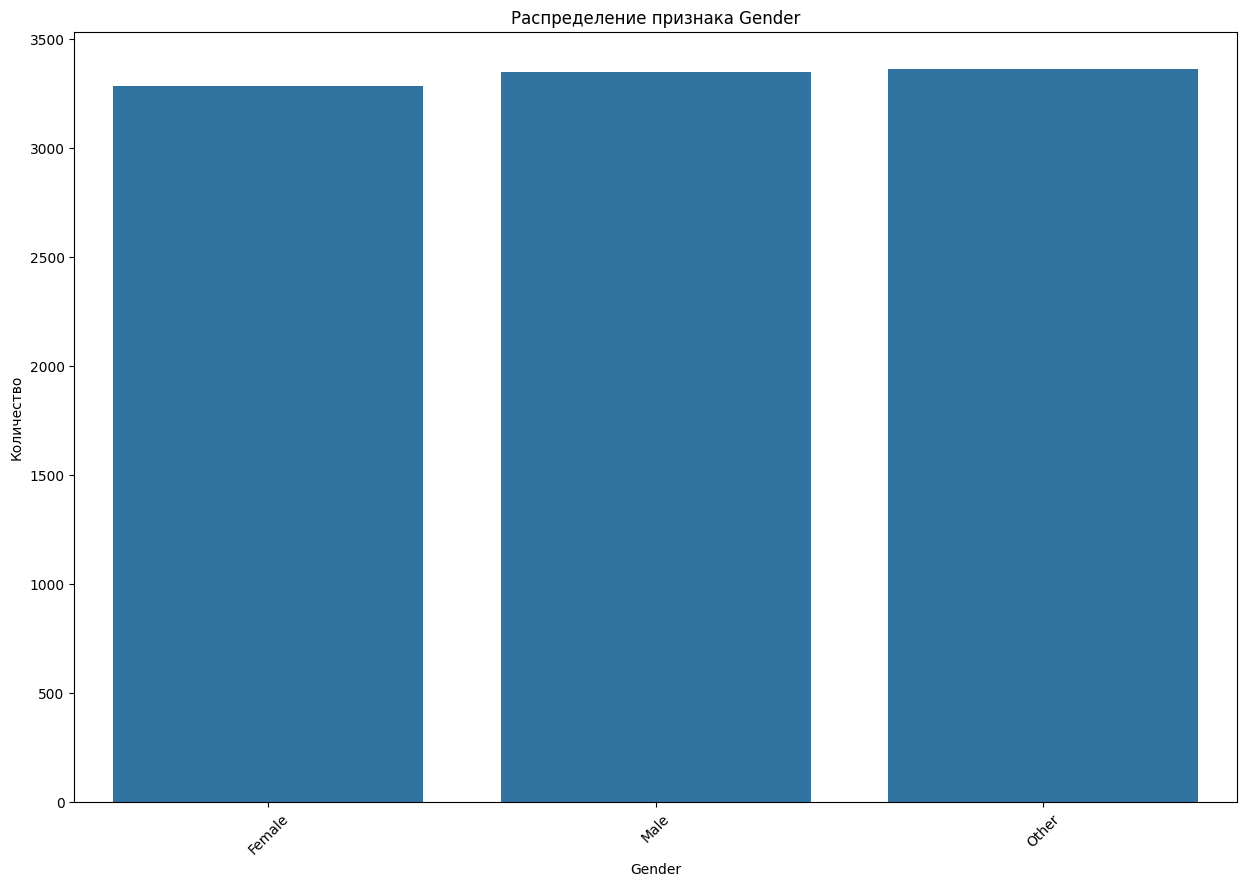

Базовая статистика для Gender:
count     10000
unique        3
top       Other
freq       3364
Name: Gender, dtype: object

--------------------------------------------------

Анализ распределения для признака: Technology_Usage_Hours


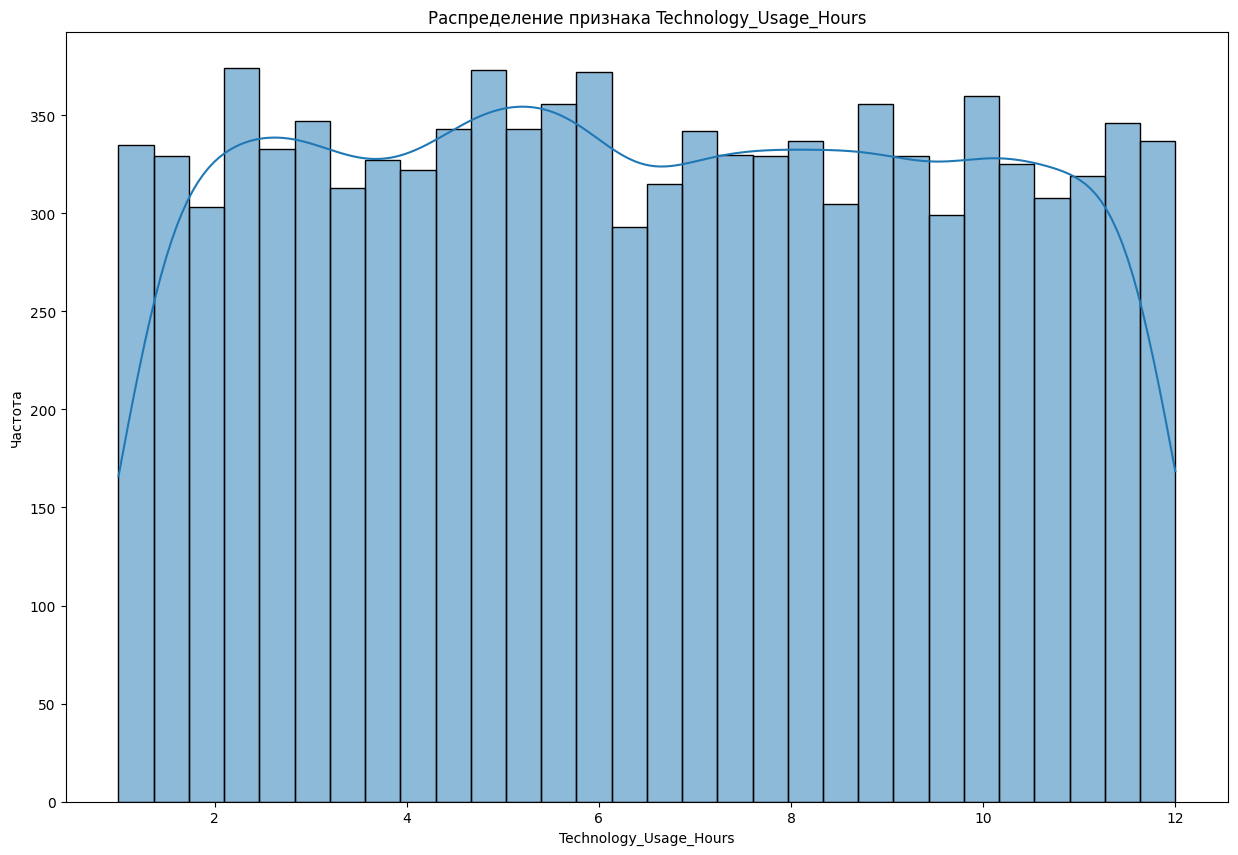

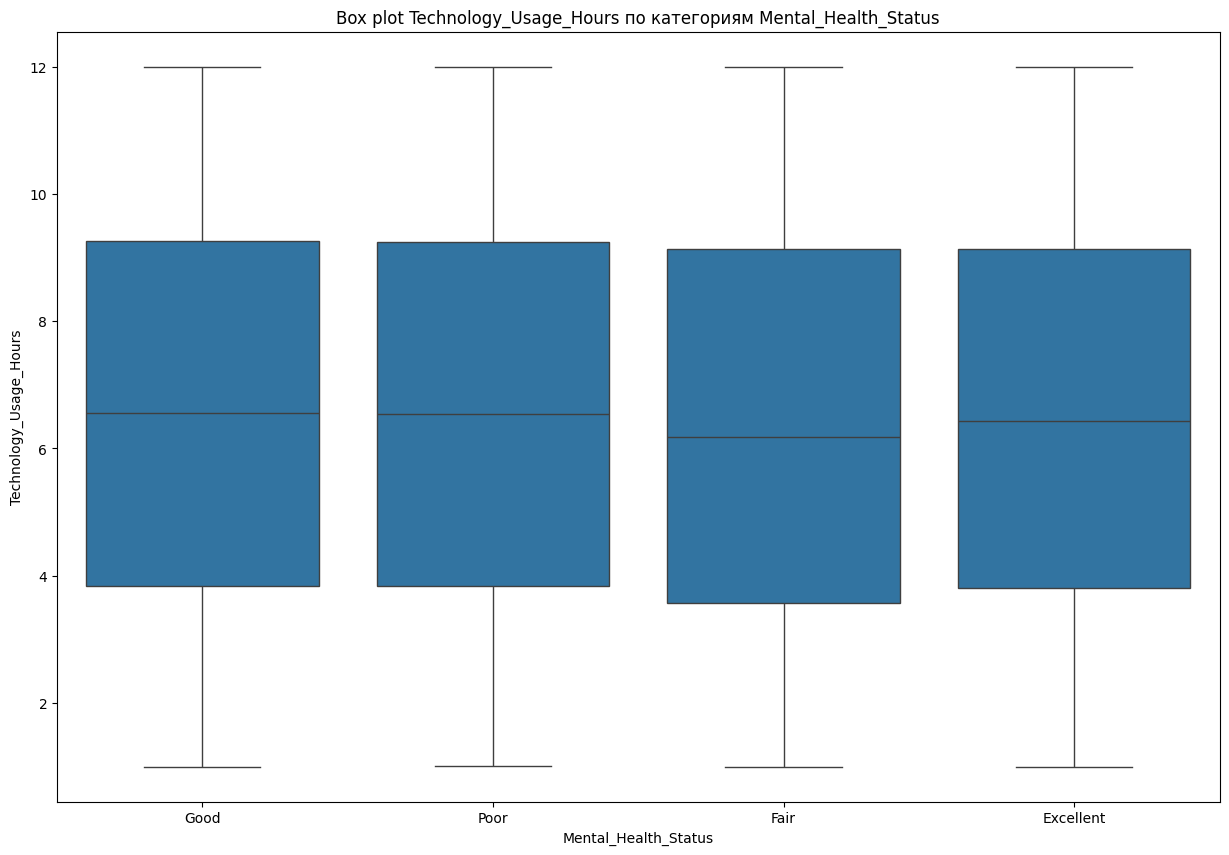

Базовая статистика для Technology_Usage_Hours:
count    10000.000000
mean         6.474341
std          3.169022
min          1.000000
25%          3.760000
50%          6.425000
75%          9.212500
max         12.000000
Name: Technology_Usage_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Social_Media_Usage_Hours


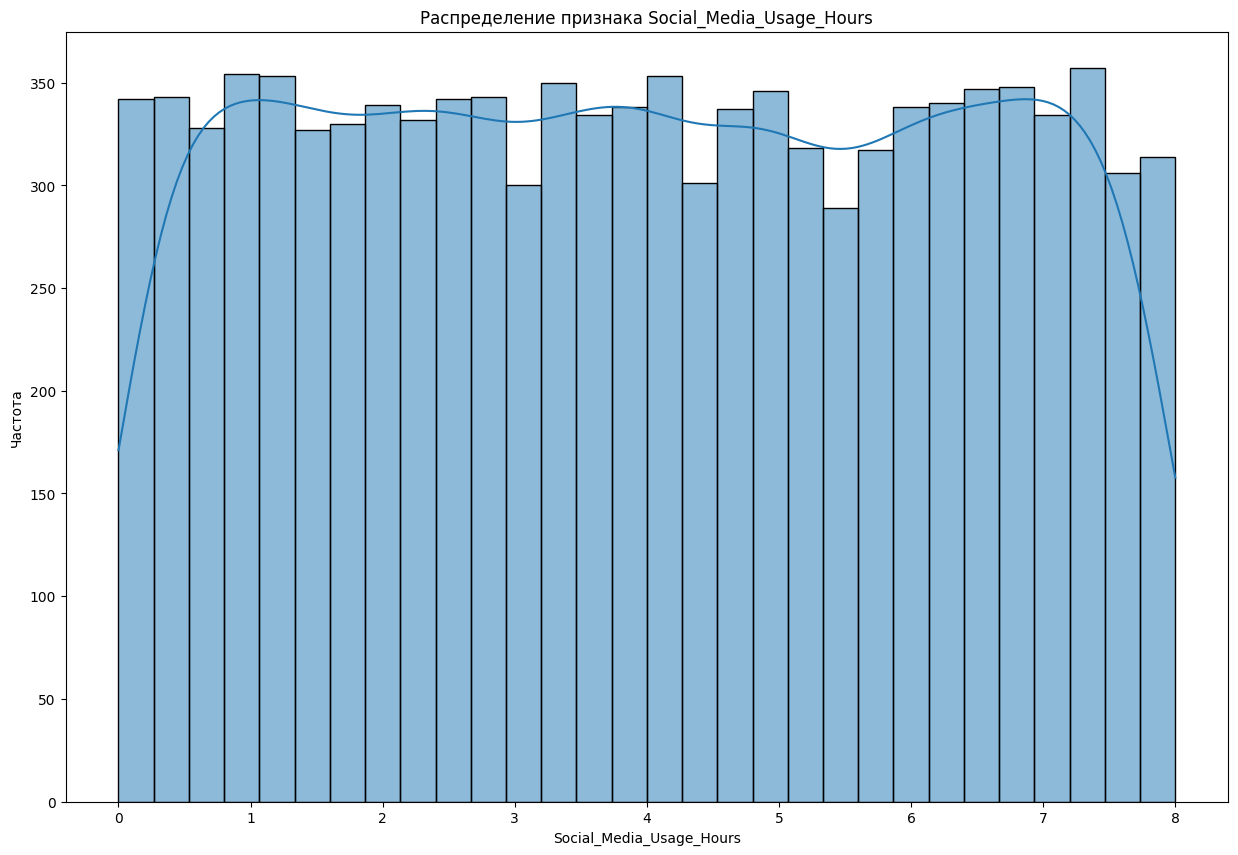

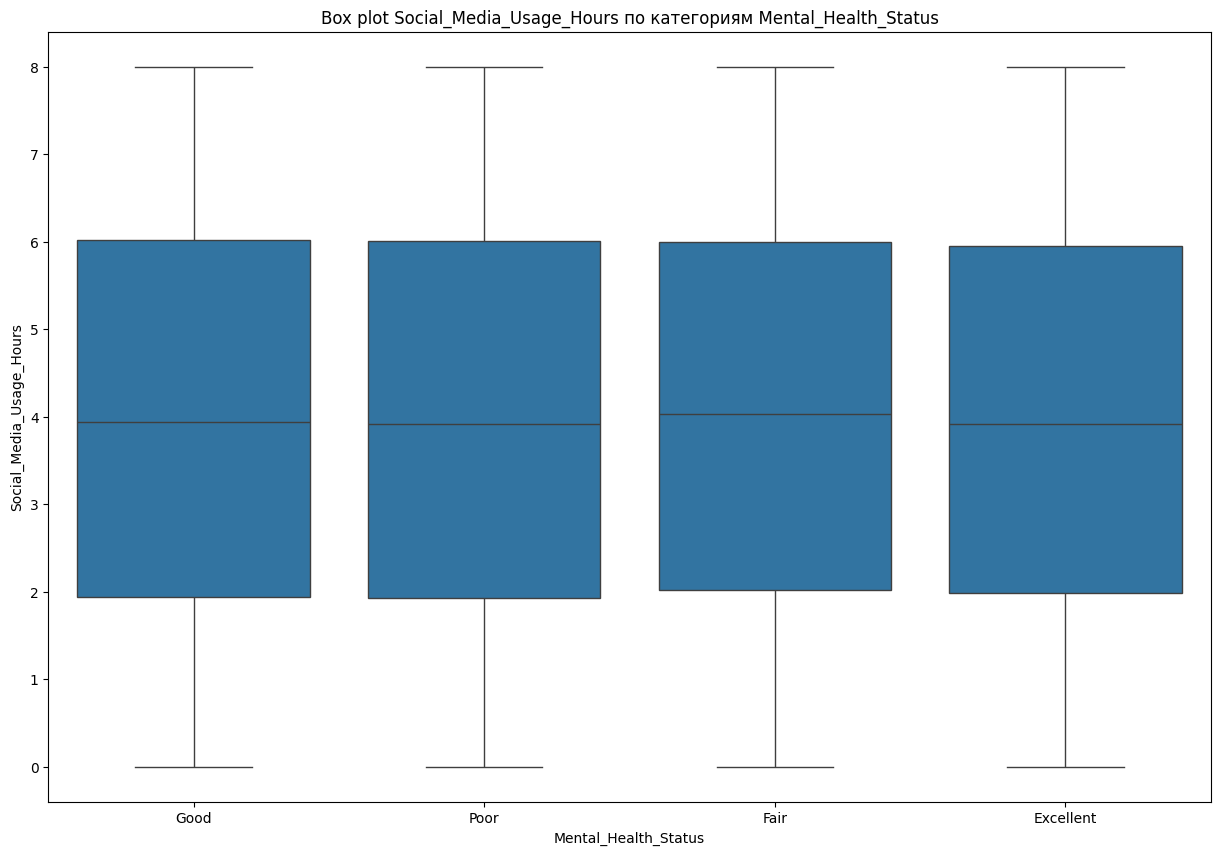

Базовая статистика для Social_Media_Usage_Hours:
count    10000.000000
mean         3.972321
std          2.313707
min          0.000000
25%          1.980000
50%          3.950000
75%          5.990000
max          8.000000
Name: Social_Media_Usage_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Gaming_Hours


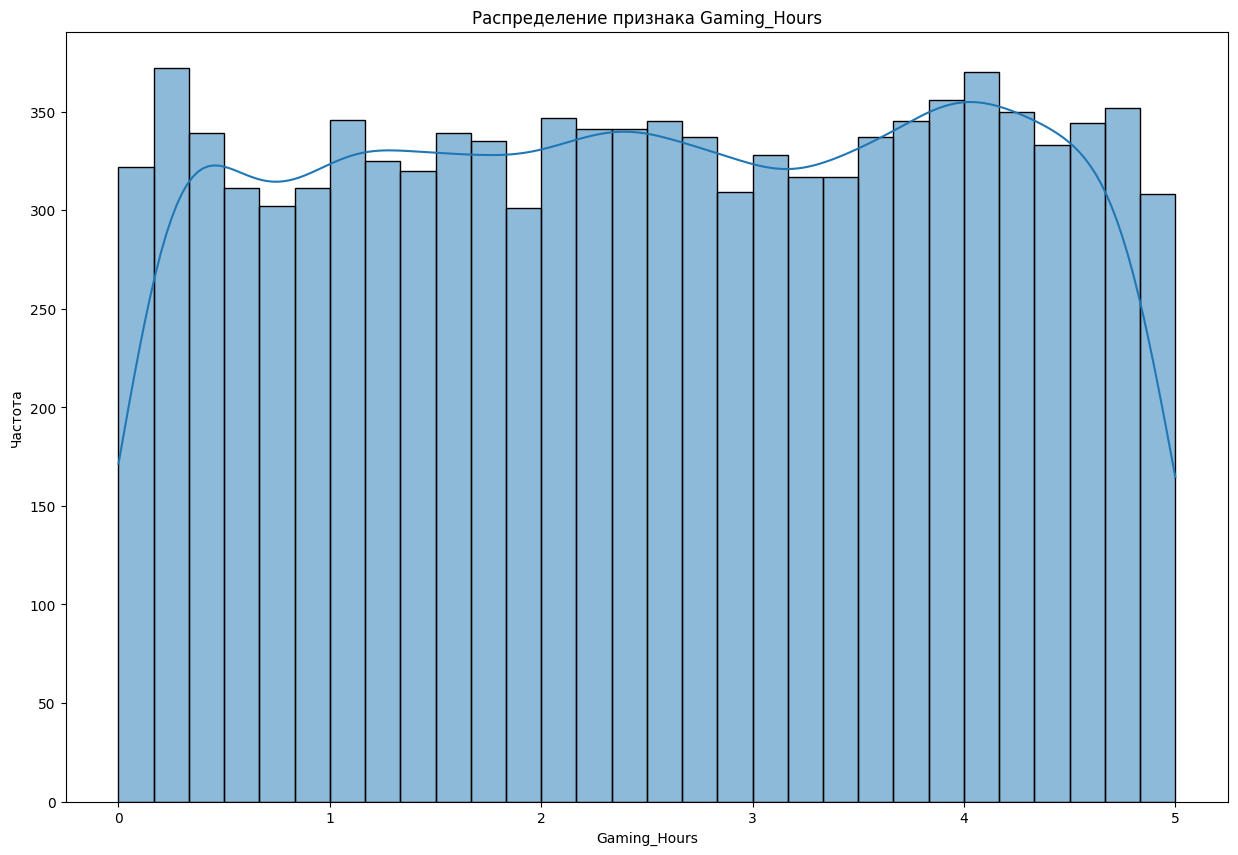

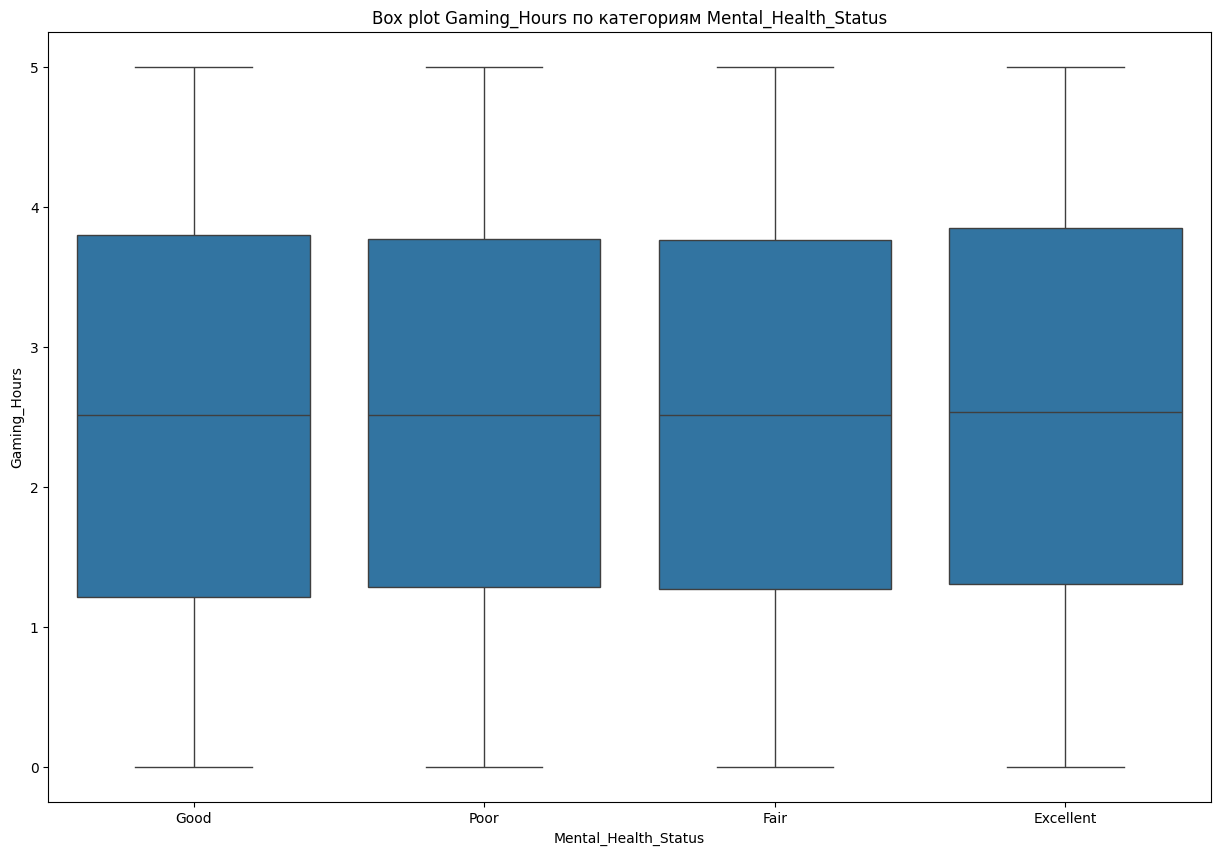

Базовая статистика для Gaming_Hours:
count    10000.000000
mean         2.515598
std          1.446748
min          0.000000
25%          1.260000
50%          2.520000
75%          3.790000
max          5.000000
Name: Gaming_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Screen_Time_Hours


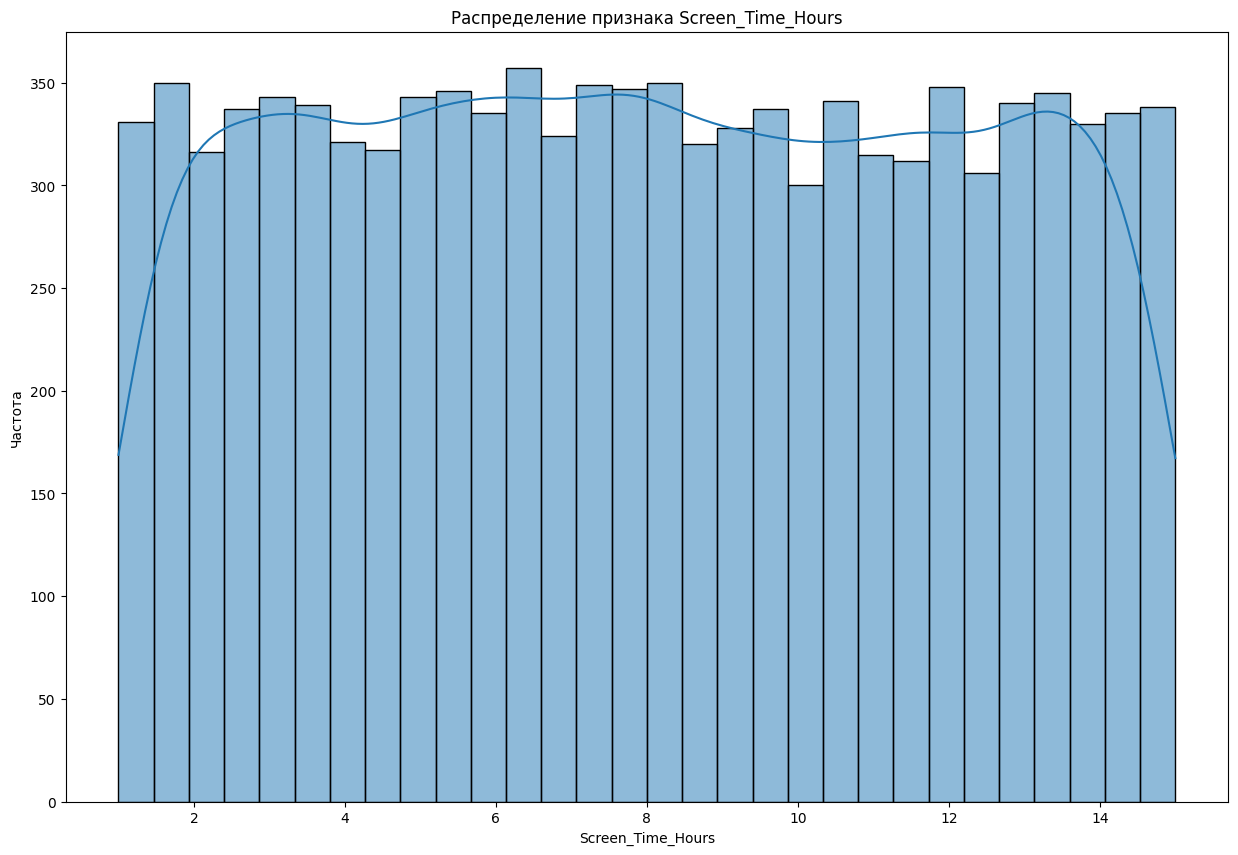

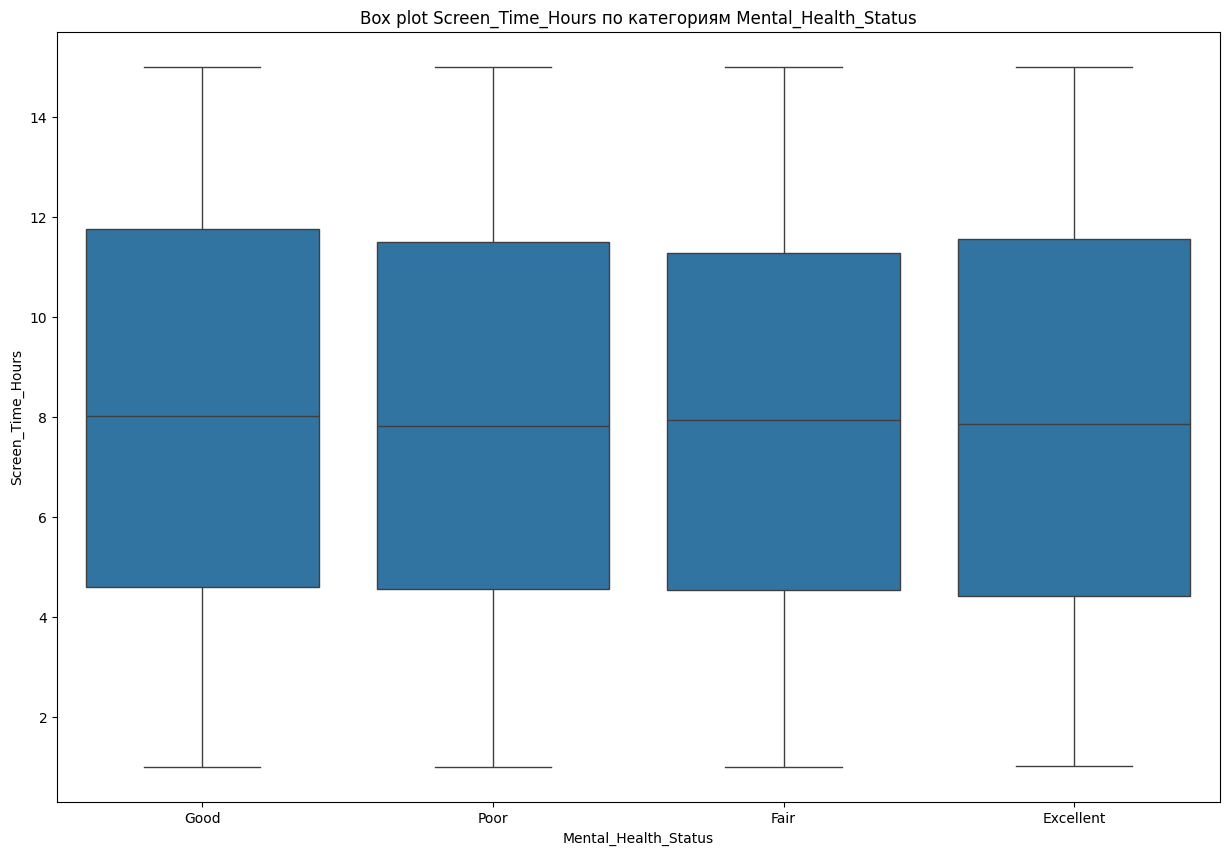

Базовая статистика для Screen_Time_Hours:
count    10000.000000
mean         7.975765
std          4.042608
min          1.000000
25%          4.520000
50%          7.900000
75%         11.500000
max         15.000000
Name: Screen_Time_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Stress_Level


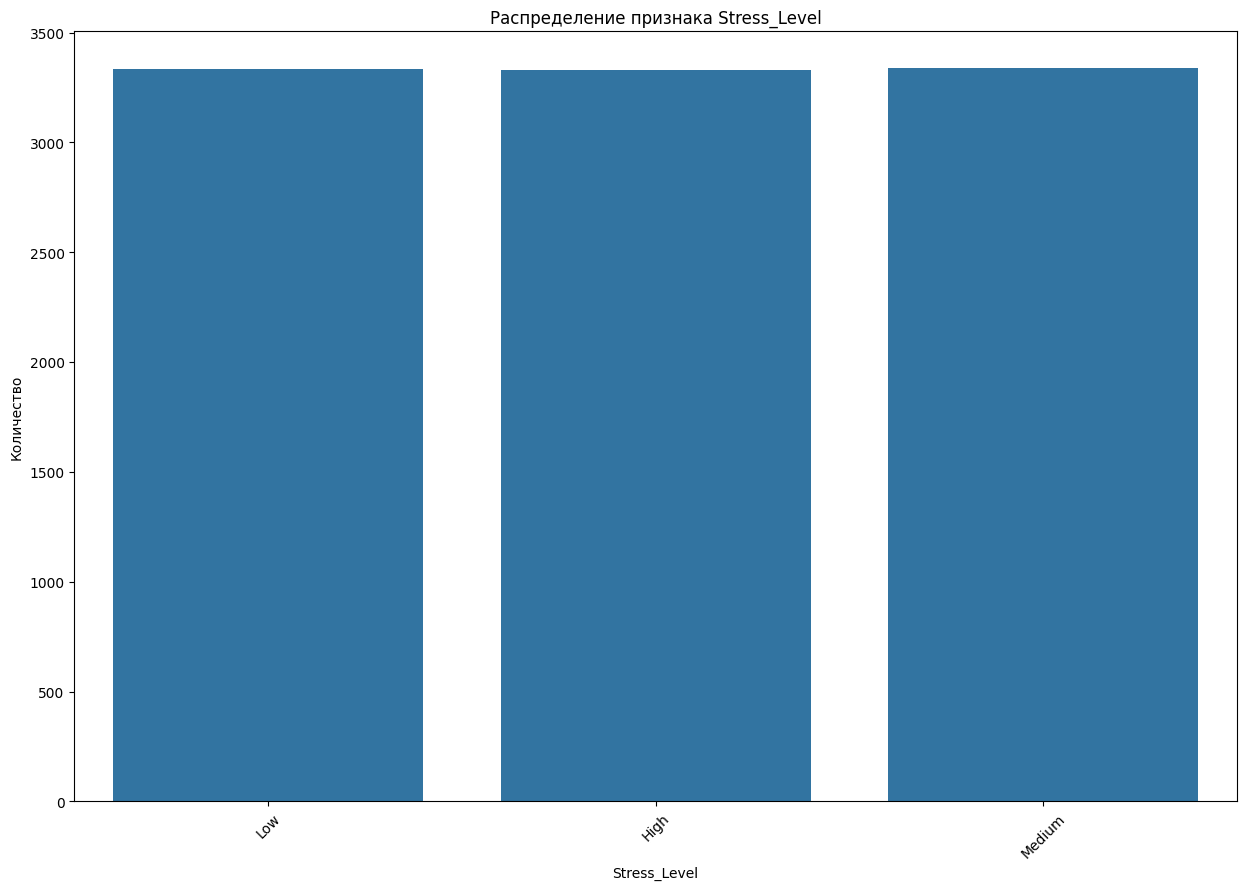

Базовая статистика для Stress_Level:
count      10000
unique         3
top       Medium
freq        3338
Name: Stress_Level, dtype: object

--------------------------------------------------

Анализ распределения для признака: Sleep_Hours


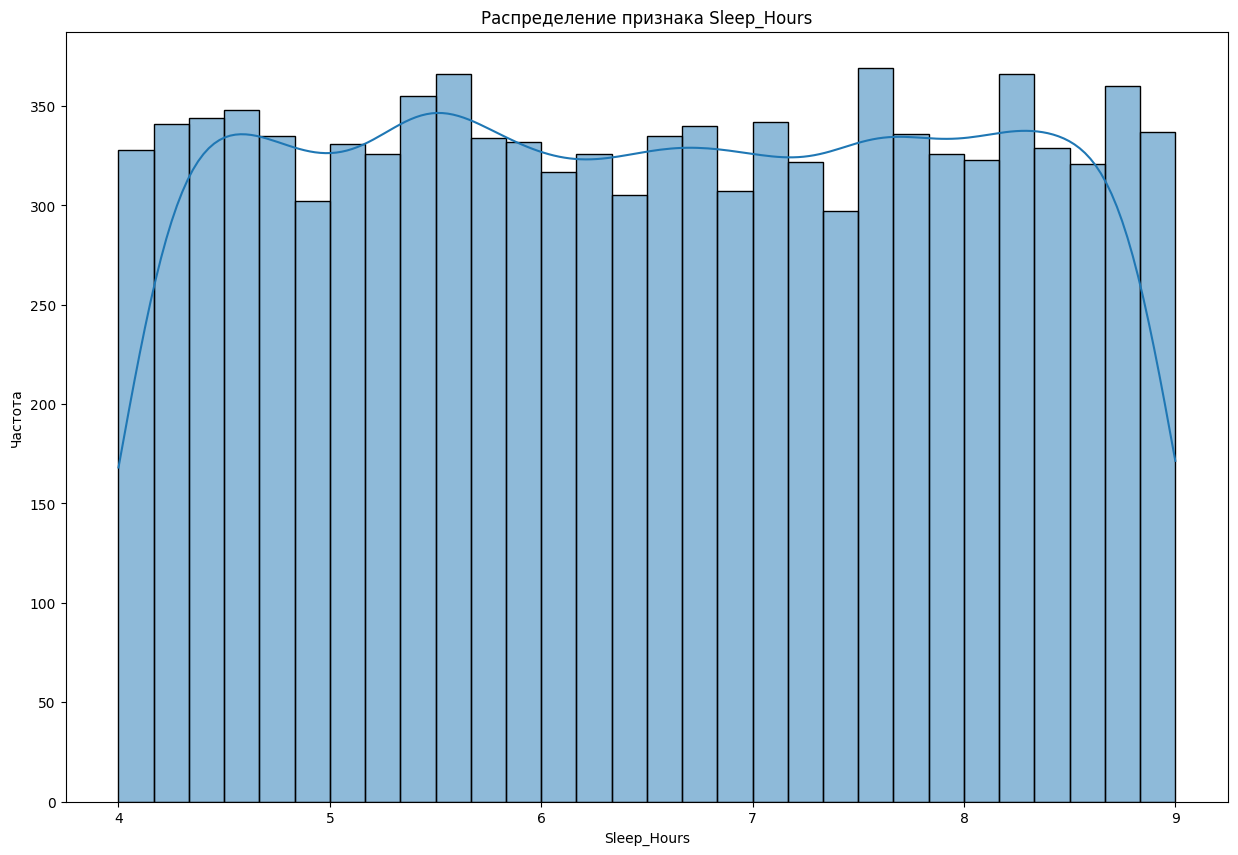

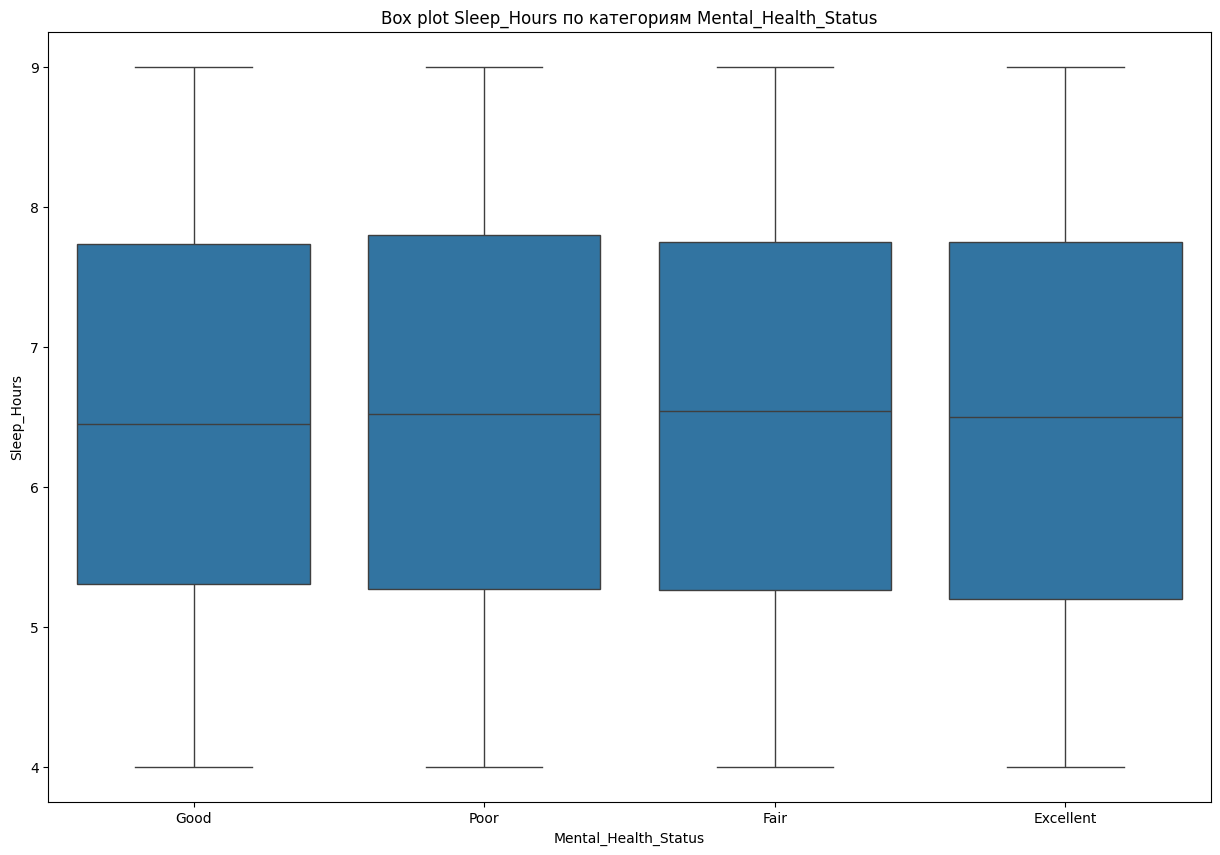

Базовая статистика для Sleep_Hours:
count    10000.000000
mean         6.500724
std          1.450933
min          4.000000
25%          5.260000
50%          6.500000
75%          7.760000
max          9.000000
Name: Sleep_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Physical_Activity_Hours


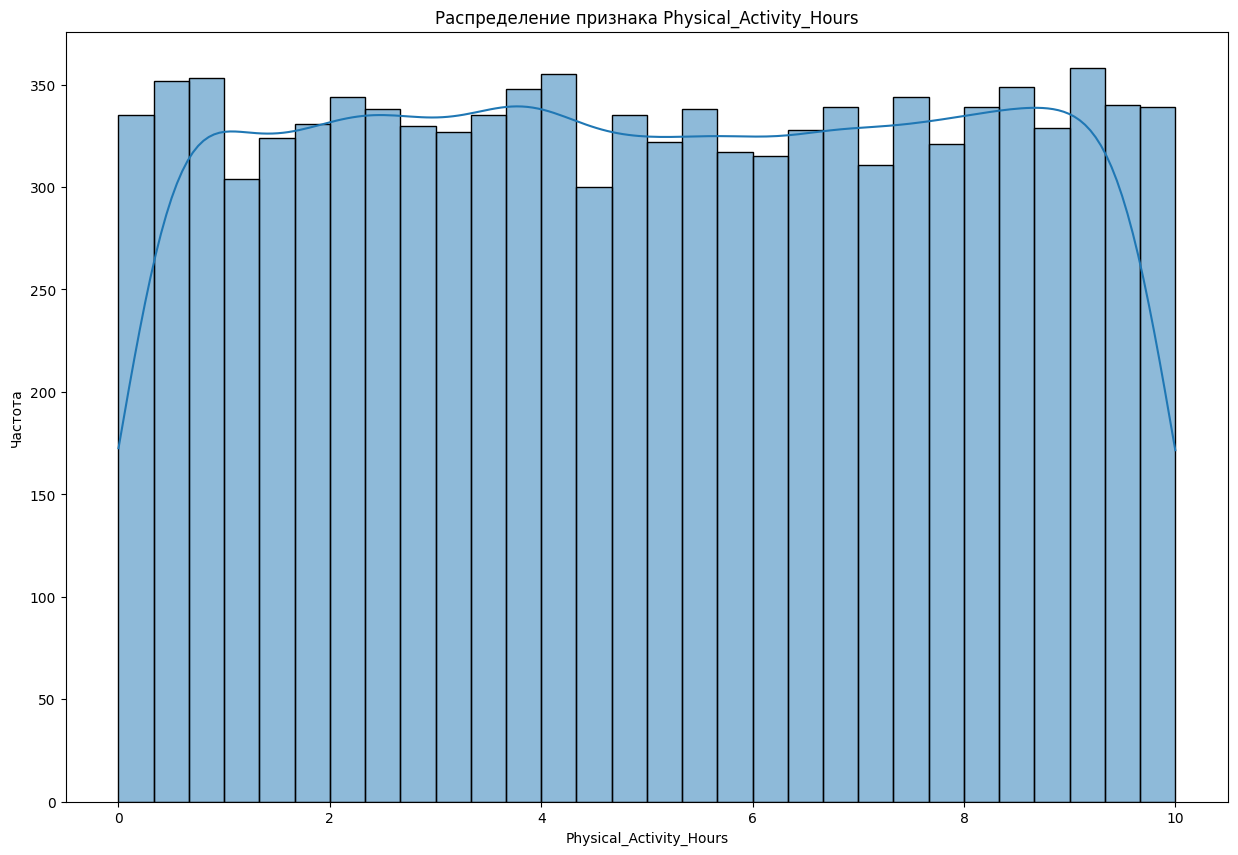

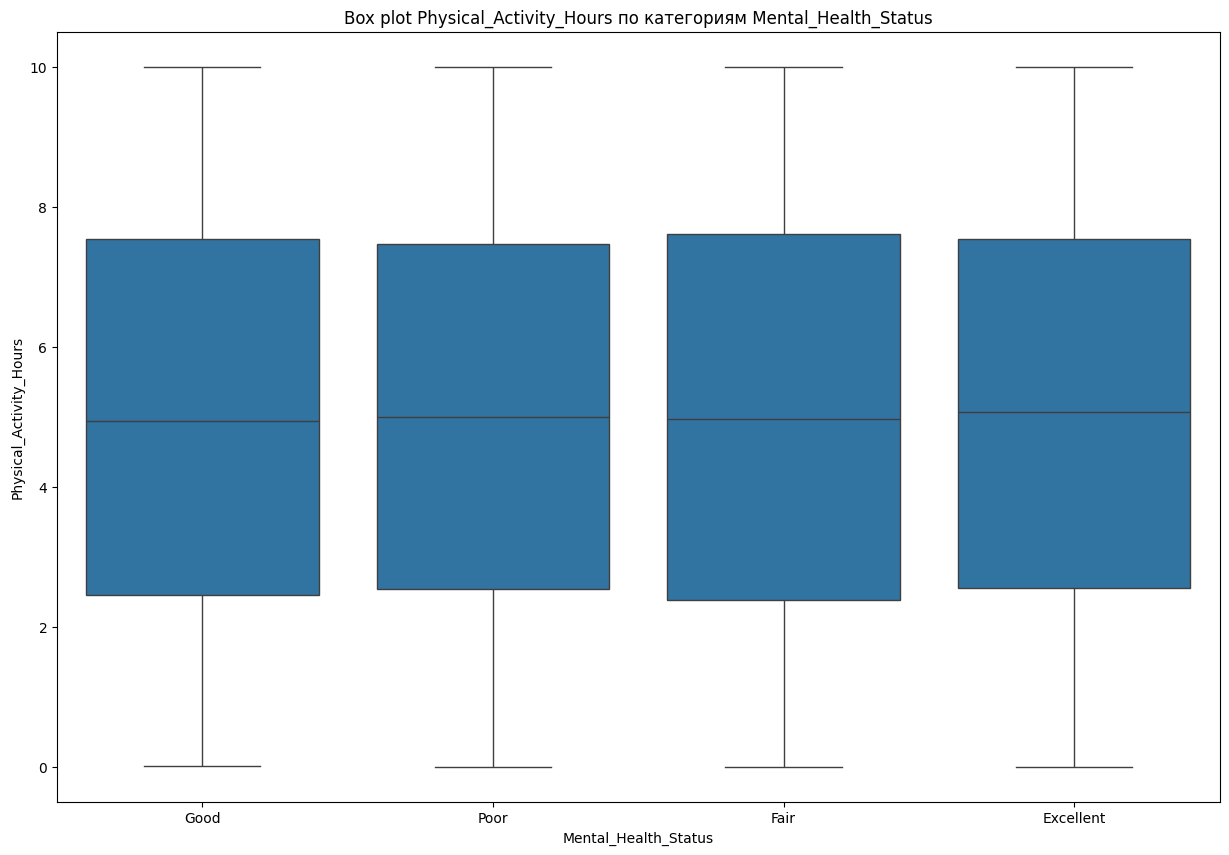

Базовая статистика для Physical_Activity_Hours:
count    10000.000000
mean         5.003860
std          2.905044
min          0.000000
25%          2.490000
50%          4.990000
75%          7.540000
max         10.000000
Name: Physical_Activity_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Support_Systems_Access


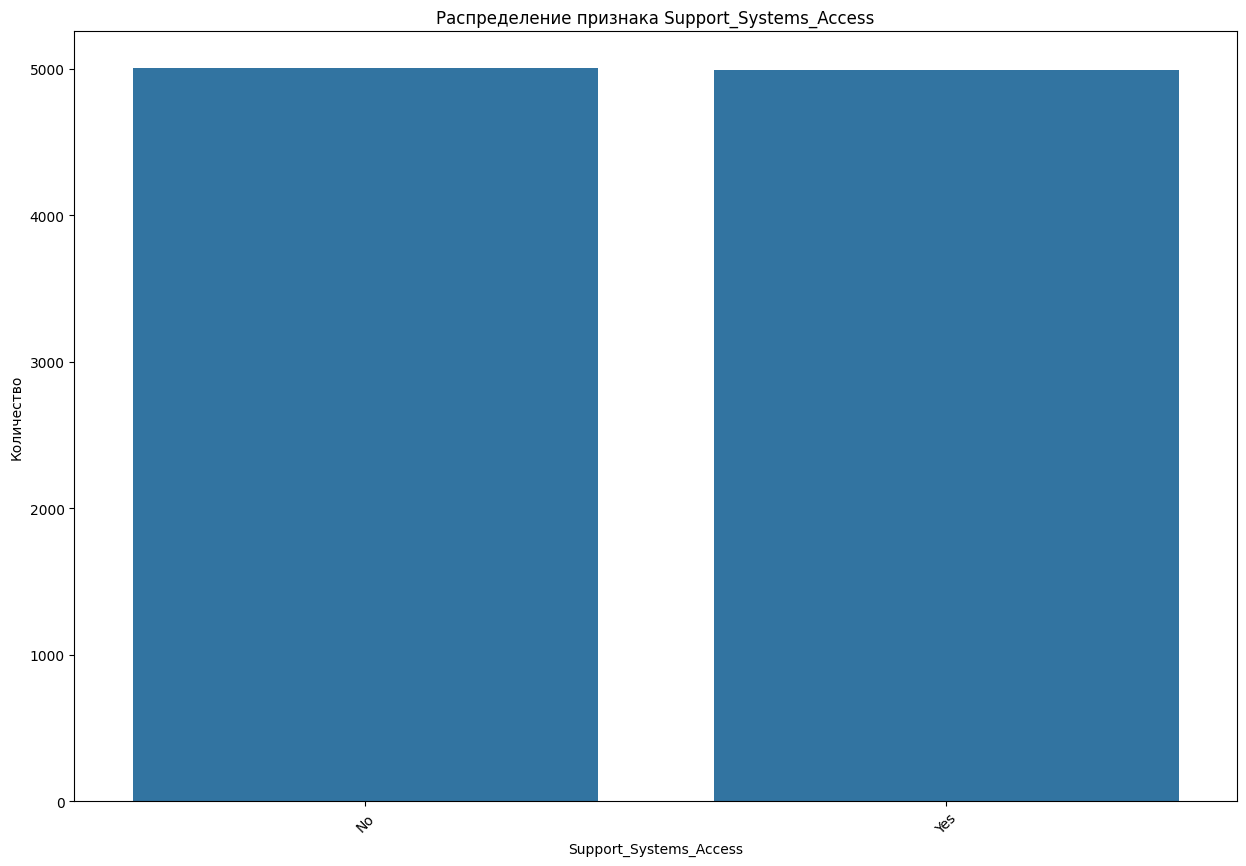

Базовая статистика для Support_Systems_Access:
count     10000
unique        2
top          No
freq       5006
Name: Support_Systems_Access, dtype: object

--------------------------------------------------

Анализ распределения для признака: Work_Environment_Impact


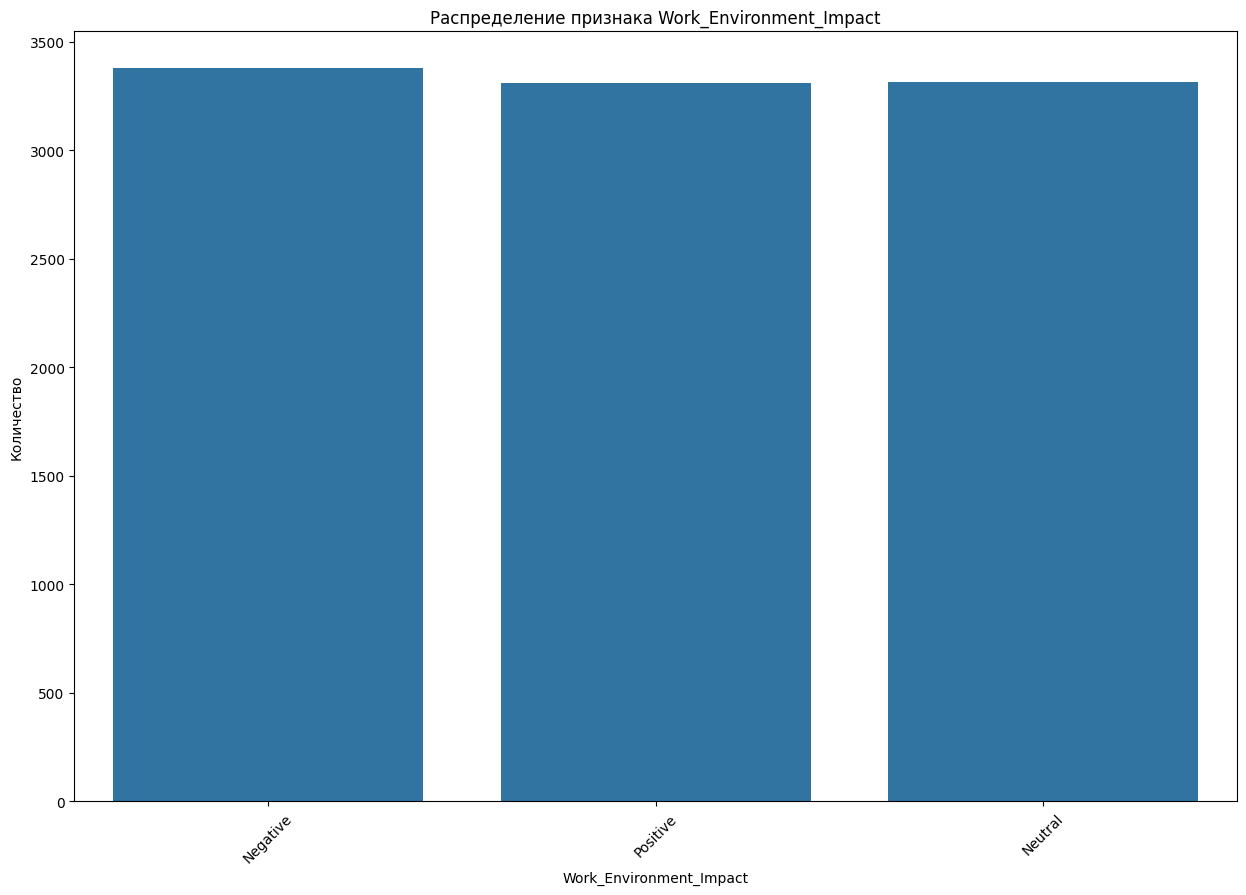

Базовая статистика для Work_Environment_Impact:
count        10000
unique           3
top       Negative
freq          3378
Name: Work_Environment_Impact, dtype: object

--------------------------------------------------

Анализ распределения для признака: Online_Support_Usage


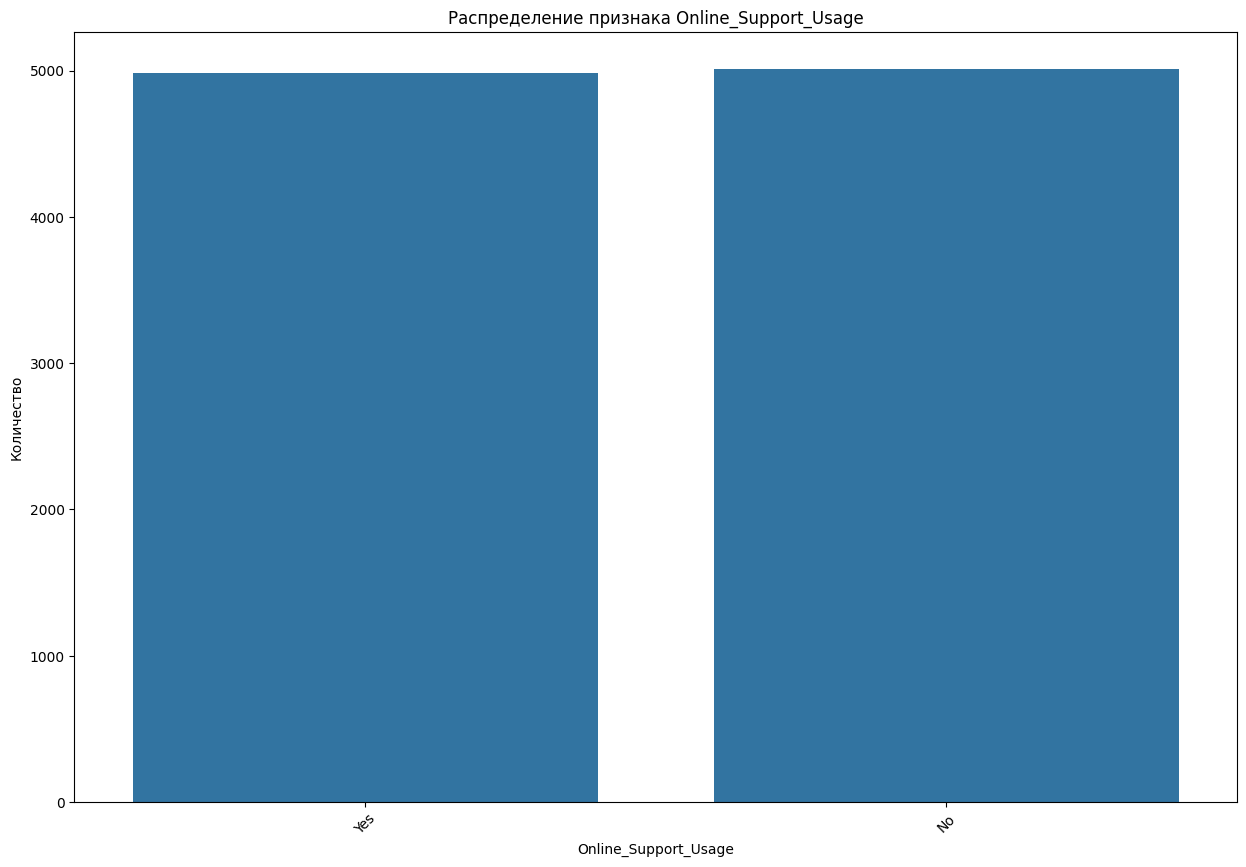

Базовая статистика для Online_Support_Usage:
count     10000
unique        2
top          No
freq       5013
Name: Online_Support_Usage, dtype: object

--------------------------------------------------


In [109]:
def plot_numeric_distribution(data, column, bins=30, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.histplot(data[column], kde=True, bins=bins)
    plt.title(f'Распределение признака {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

def plot_categorical_distribution(data, column, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=column)
    plt.title(f'Распределение признака {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()


def plot_box_plot(data, numeric_column, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, x='Mental_Health_Status', y=numeric_column)
    plt.title(f'Box plot {numeric_column} по категориям Mental_Health_Status')
    plt.xlabel('Mental_Health_Status')
    plt.ylabel(numeric_column)
    plt.show()

def plot_all_distributions(data, figsize=(15, 10), exclude_columns=['User_ID', 'Mental_Health_Status']):
    """
    Построение графиков распределения для всех признаков-предикторов в датасете.
    
    :param data: DataFrame с данными
    :param figsize: базовый размер графика
    :param exclude_columns: список столбцов для исключения из анализа
    """
    for column in data.columns:
        if column not in exclude_columns:
            print(f"\nАнализ распределения для признака: {column}")
            
            if data[column].dtype in ['int64', 'float64']:
                plot_numeric_distribution(data, column, figsize=figsize)
                plot_box_plot(data, column, figsize=figsize)
            else:
                plot_categorical_distribution(data, column, figsize=figsize)
            
            print(f"Базовая статистика для {column}:")
            print(data[column].describe())
            print("\n" + "-"*50)

plot_all_distributions(data)

# Вывод по распределению признаков

## 1. Демографические характеристики

### Возраст (Age)
- Распределение: Относительно равномерное от 20 до 60+ лет
- Медиана: Около 40-42 лет

## 2. Факторы окружающей среды

### Work_Environment_Impact
- Категории: Negative, Positive, Neutral
- Распределение: Примерно равномерное с небольшим преобладанием негативного влияния

## 3. Системы поддержки

### Online_Support_Usage
- Тип: Бинарный (Yes/No)
- Распределение: Почти равномерное между использованием и неиспользованием

### Support_Systems_Access
- Тип: Бинарный (Yes/No)
- Распределение: Примерно равномерное, с небольшим преобладанием отсутствия доступа

## 4. Образ жизни

### Sleep_Hours
- Распределение: Близко к нормальному, пик около 6-7 часов

### Physical_Activity_Hours
- Распределение: Смещено вправо, пик около 2-3 часов

## Общие наблюдения

1. Распределения многих признаков (возраст, использование онлайн-поддержки, доступ к системам поддержки) близки к равномерным.
2. Факторы рабочей среды, сна и физической активности показывают некоторую вариативность в распределении.

## Рекомендации

1. Провести дополнительный статистический анализ для более глубокого понимания распределений.
2. Рассмотреть возможность построения многофакторных моделей для оценки взаимосвязей между различными признаками.
3. Исследовать возможные нелинейные зависимости в данных.
4. Провести анализ взаимодействия между различными признаками для выявления комплексных паттернов.

### Посмотрим графики зависимости Mental Health от всех остальных признаков

# Проведем статистические тесты для оценки значимости различий между группами

In [110]:

def perform_statistical_tests(data):
    results = []
    numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = data.select_dtypes(include=['object']).columns
    
    for feature in numeric_features:
        if feature != 'User_ID':
            f_statistic, p_value = stats.f_oneway(*[group[feature].values for name, group in data.groupby('Mental_Health_Status')])
            results.append({
                'Feature': feature,
                'Test': 'ANOVA',
                'Statistic': f_statistic,
                'p-value': p_value
            })
    
    for feature in categorical_features:
        if feature != 'Mental_Health_Status':
            contingency_table = pd.crosstab(data[feature], data['Mental_Health_Status'])
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
            results.append({
                'Feature': feature,
                'Test': 'Chi-square',
                'Statistic': chi2,
                'p-value': p_value
            })
    
    df_results = pd.DataFrame(results)
    df_results.columns = ['Feature', 'Test', 'Statistic', 'p-value']
    
    return df_results

def plot_correlation_matrix(data):
    numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
    correlation_matrix = data[numeric_features].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title("Корреляционная матрица числовых признаков")
    plt.tight_layout()
    plt.show()


In [111]:
statistical_results = perform_statistical_tests(data)
df_results = statistical_results.to_csv('./data/statistical_results.csv', index=False)
statistical_results

,Feature,Test,Statistic,p-value
0,Age,ANOVA,1.610324,0.184673
1,Technology_Usage_Hours,ANOVA,2.415171,0.064536
2,Social_Media_Usage_Hours,ANOVA,0.808867,0.488734
3,Gaming_Hours,ANOVA,0.522589,0.666731
4,Screen_Time_Hours,ANOVA,0.878873,0.451143
5,Sleep_Hours,ANOVA,0.301214,0.824548
6,Physical_Activity_Hours,ANOVA,0.499882,0.682360
7,User_ID,Chi-square,30000.000000,0.494028
8,Gender,Chi-square,6.591223,0.360309
9,Stress_Level,Chi-square,4.789712,0.571053


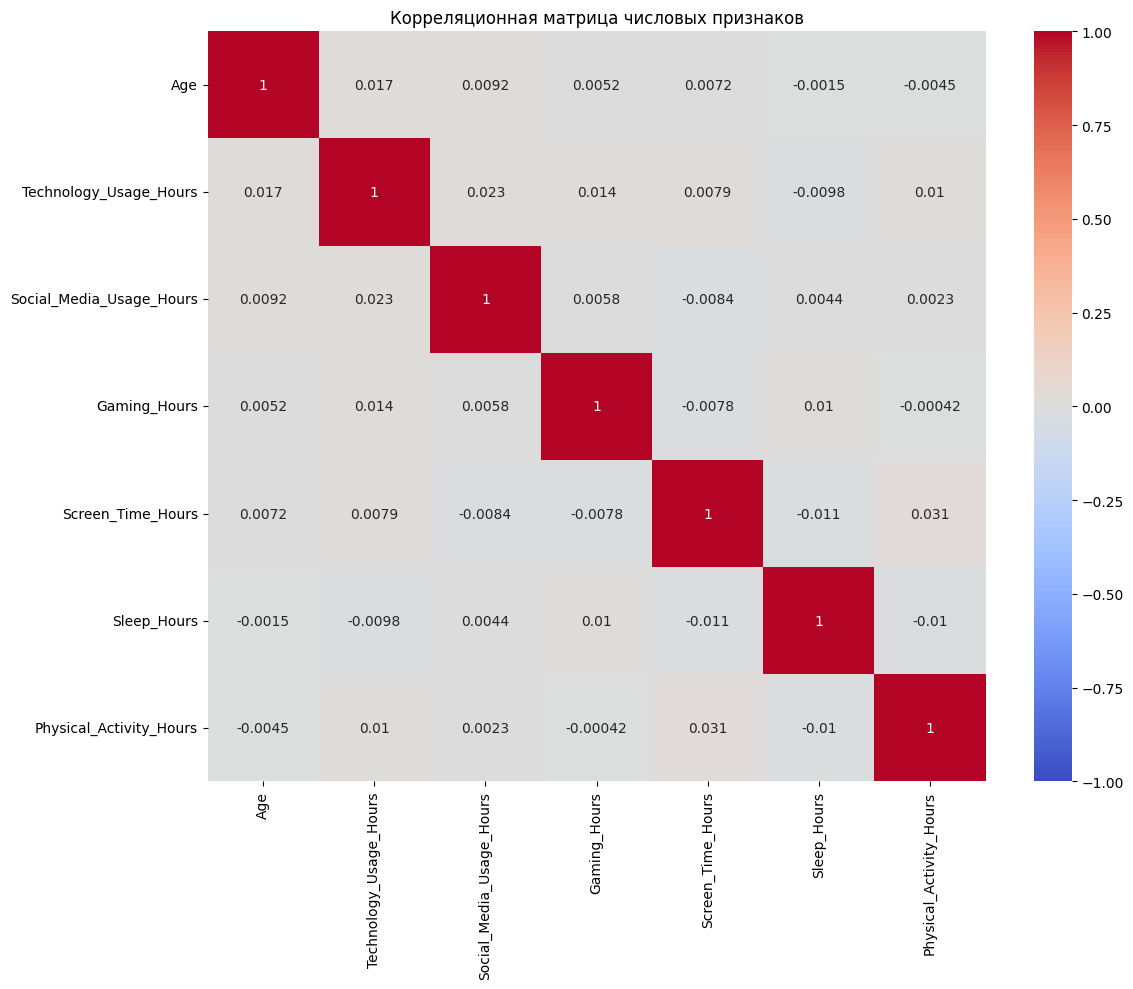

In [112]:
plot_correlation_matrix(data)

# Вывод по анализу связи Mental_Health_Status с другими переменными

## Основные результаты

1. **Слабая связь большинства переменных**: Предыдущий анализ показал, что большинство исследуемых переменных не имеют статистически значимой связи с Mental_Health_Status.

2. **Значимость доступа к системам поддержки**: Support_Systems_Access остается единственной переменной, показавшей статистически значимую связь с Mental_Health_Status (p-value = 0.0397).

3. **Потенциальное влияние использования технологий**: Technology_Usage_Hours показала наименьшее p-значение (0.0645) среди непрерывных переменных, хотя и не достигла уровня статистической значимости.

4. **Отсутствие сильных корреляций между числовыми признаками**: Корреляционная матрица демонстрирует очень слабые корреляции между всеми числовыми переменными.

## Интерпретация результатов

1. **Независимость факторов**: Очень низкие значения корреляции (максимальное значение 0.031 между Screen_Time_Hours и Physical_Activity_Hours) указывают на то, что исследуемые числовые переменные практически не связаны друг с другом. Это может свидетельствовать о том, что каждая переменная представляет собой независимый фактор в контексте данного исследования.

2. **Комплексность психического здоровья**: Отсутствие сильных связей между переменными и с Mental_Health_Status подчеркивает сложную природу психического здоровья. Оно, вероятно, определяется сложным взаимодействием многих факторов, которые не могут быть легко выявлены простыми линейными методами.

3. **Важность социальной поддержки**: Значимая связь с Support_Systems_Access (выявленная в предыдущем анализе) остается ключевым результатом, особенно учитывая отсутствие сильных корреляций между числовыми переменными.

4. **Отсутствие явных паттернов использования технологий**: Слабые корреляции между Technology_Usage_Hours, Social_Media_Usage_Hours, Gaming_Hours и Screen_Time_Hours указывают на отсутствие четких паттернов в использовании различных типов технологий.

## Ограничения анализа

1. **Линейные зависимости**: Использованные методы выявляют только линейные зависимости. Возможно наличие нелинейных связей, которые не были обнаружены.

2. **Отсутствие учета взаимодействий**: Анализ не учитывает возможные сложные взаимодействия между переменными, которые могут влиять на Mental_Health_Status.

3. **Ограниченный набор переменных**: Возможно существование других важных факторов, влияющих на психическое здоровье, которые не были включены в данный набор данных.

4. **Потенциальная недостаточность линейных методов**: Очень низкие корреляции могут указывать на необходимость применения более сложных, нелинейных методов анализа.

## Рекомендации для дальнейшего исследования

1. Углубленное изучение влияния систем поддержки на психическое здоровье, учитывая его выделяющуюся значимость на фоне отсутствия других сильных связей.

2. Исследование нелинейных зависимостей и сложных взаимодействий между переменными, используя методы машинного обучения (например, случайные леса или градиентный бустинг).

3. Применение методов кластерного анализа для выявления возможных подгрупп в данных, которые могут демонстрировать различные паттерны связей между переменными.

4. Сбор дополнительных данных о факторах, потенциально влияющих на психическое здоровье, особенно качественных показателей, которые могут дополнить количественные данные.

5. Проведение факторного анализа для выявления возможных латентных переменных, которые могут объяснить наблюдаемые паттерны в данных.

6. Рассмотрение возможности проведения лонгитюдного исследования для отслеживания изменений психического здоровья во времени и выявления причинно-следственных связей.